In [1]:
import sys
sys.path.append('..')

In [2]:
from ipynb.plot_pcvrp import discrete_cmap
from ipynb.plot_pcvrp import plot_vehicle_routes
from asist.get_attention_problem import *

from asist.graph import VictimType

import os
import numpy as np
import torch
import pickle
import json

from torch.utils.data import DataLoader
from utils import load_model
from problems import PCVRP

from matplotlib import pyplot as plt

torch.manual_seed(1000)

In [24]:
# sm_data_path = os.path.join('data', 'json', 'Saturn', 'Saturn_1.5_3D_sm_with_victimsA.json')
sm_data_path = os.path.join('data', 'json', 'Saturn', 'Saturn_trial_416.json')
# medic_model_path = os.path.join('..', 'outputs', '2021-6-23', 'graph_size=55,price_mode=1,high_value=1')
medic_model_path = os.path.join('..', 'pretrained_asist', 'medic', 'cvrp_baseline')
# engineer_model_path = os.path.join('..', 'outputs', '2021-7-28', '0')
engineer_model_path = os.path.join('..', 'outputs', '2021-8-2', 'exp-baseline-2-1757')
# engineer_model_path = os.path.join('..', 'outputs', '2021-8-2', 'exp-baseline-004-5271')


medic_pickle_file = "saturn_A_1.5_medic.pkl"
medic_fig_path = os.path.join('..', 'images', 'medic.png')
engineer_fig_path = os.path.join('..', 'images', 'engineer.png')
output_path_json_path = os.path.join('..', 'images', 'sprint_cvrp_highpenalty_2.json')

In [11]:
medic_model_, _ = load_model(medic_model_path)
engineer_model_, _ = load_model(engineer_model_path)

  [*] Loading model from ..\pretrained_asist\medic\cvrp_baseline\epoch-49.pt
  [*] Loading model from ..\outputs\2021-8-2\exp-baseline-2-1757\epoch-9.pt


In [110]:
class RouteGen:
    def __init__(self, sm_data_path, medic_model_path, engineer_model_path):
        self.high_value = 1
        self.PRICE_MODE = 1
        self.medic_speed = 4.32 * 1.3
        self.engineer_speed = 3.02 * 1.3
        self.medic_graph_size = 25
        self.engineer_graph_size = 8
        self.MEDIC_TOOL_DURABILITY = 20
        self.ENGINEER_TOOL_DURABILITY = 131
        self.RUBBLE_GRAPH_SIZE = 7
        self.HIGH_VALUE_VICTIM_SIZE = 3
#         self.jl_transform_seed = 2037
        self.jl_transform_seed = 196
        self.depot_room_id = 'ew_1'
        self.loadSMData(sm_data_path)
        self.graph = MapParser.parse_saturn_map(self.sm_data)
#         self.medic_model, self.engineer_model = self.loadRouteModel(medic_model_path, engineer_model_path)
        self.rubble_normal_highvalue_victim = self.sm_data["blocking_rubble"]


    def loadSMData(self, sm_json_file):
        with open(sm_data_path) as sm_json_file:
            self.sm_data = json.load(sm_json_file)

    def loadRouteModel(self, medic=None, engineer=None):
        assert medic is not None or engineer is not None, "need to load at least one model"
        medic_model, _ = load_model(medic) if medic is not None else None
        engineer_model, _ = load_model(engineer) if engineer is not None else None
        return medic_model, engineer_model

    def get_ordered_node_list(self):
        victim_list_copy = self.graph.victim_list.copy()
        victim_list_reordered = []
        for v in self.rubble_normal_highvalue_victim:
            victim_list_reordered.append(self.graph[v])
        for v in victim_list_copy:
            if v not in victim_list_reordered:
                victim_list_reordered.append(v)
#         for iii in victim_list_reordered:
#             print(iii.id)
        self.victim_list = victim_list_reordered
        self.node_list = [self.graph[self.depot_room_id]] + victim_list_reordered
        self.engineer_node_list = [self.graph[self.depot_room_id]] + \
                                victim_list_reordered[:self.RUBBLE_GRAPH_SIZE] + \
                                victim_list_reordered[-self.HIGH_VALUE_VICTIM_SIZE:]
#         print('*' * 30)
#         for jjj in self.engineer_node_list:
#             print(jjj.id)

    def remove_saved_victims(self):
        save_before_change = [(-2148, 55), (-2132, 17), (-2126, 13), (-2128, 19), (-2133, 22), (-2090, 23), (-2093, 52), (-2108, 13), (-2094, 34), (-2092, 30), (-2089, 57), (-2088, 48), (-2099, 38), (-2094, 3), (-2098, 4), (-2178, 1), (-2195, -1), (-2193, -1), (-2197, -1), (-2216, 12), (-2216, 13)]
        save_after_change = [(-2207, 13), (-2201, 13), (-2217, 35), (-2224, 45), (-2215, 58), (-2205, 59), (-2222, 49), (-2195, 57)]
        save_before_list = []
        save_after_list = []
        unsave_list = []
        for v in rg.graph.victim_list:
            if v.loc in save_before_change:
                save_before_list.append(v.id) 
            elif v.loc in save_after_change:
                save_after_list.append(v.id)
            else:
                unsave_list.append(v.id)
        self.save_before_list = save_before_list
        self.save_after_list = save_after_list
        self.unsave_list = unsave_list
        self.saved_list = self.save_before_list + self.save_after_list
        
        victim_list_copy = self.graph.victim_list.copy()
        rm_saved_list = []
        for v in victim_list_copy:
            if v.id not in self.saved_list and v.id != 'vy3':
                rm_saved_list.append(v)
        
        self.node_list = [self.graph[self.depot_room_id]] + rm_saved_list
        
        rubble_node_list = [self.graph[rb] for rb in self.rubble_normal_highvalue_victim]
        self.engineer_node_list = [self.graph[self.depot_room_id]] + \
                                rubble_node_list + \
                                [self.graph['vg10']] + [self.graph['vy4']]
        
#         print(self.node_list)
#         print(self.engineer_node_list)

    def translate2D01space(self, dump_pkl=None):
        D = get_distance_matrix_original(self.graph, self.node_list)
        higher = distance_matrix_to_coordinate(D)
        lower = np.array(jl_transform(higher, 2, seed=self.jl_transform_seed))
        loc = lower.copy()
        loc_all = lower.copy()
        lx = min(loc_all, key=lambda x: x[0])[0]
        lz = min(loc_all, key=lambda x: x[1])[1]
        rx = max(loc_all, key=lambda x: x[0])[0]
        rz = max(loc_all, key=lambda x: x[1])[1]
        span = max(rx - lx, rz - lz)
        for l in loc:
            l[0] = (l[0] - lx) / span
            l[1] = (l[1] - lz) / span
        depot, loc = loc[0].tolist(), loc[1:].tolist()
        max_length = 5.5  # set this value the same as that for trained model

        demand = [1 / self.MEDIC_TOOL_DURABILITY] * self.medic_graph_size
        prize_list = []
        for v in self.victim_list:
            if v.victim_type == VictimType.Yellow:
                prize_list.append(self.high_value)
            elif v.victim_type == VictimType.Green:
                prize_list.append(0.1)

        cord2D_obj = [(depot, loc, demand, prize_list)]

        if dump_pkl is not None:
            with open(dump_pkl, 'wb') as f:
                pickle.dump(cord2D_obj, f)

    def get_medic_tour_index(self, medic_pickle='saturn_A_1.5_medic.pkl'):
        PCVRP.switch_player_role("medic")
        medic_dataset = PCVRP.make_dataset(size=self.medic_graph_size, filename=medic_pickle)

        # Need a dataloader to batch instances
        dataloader = DataLoader(medic_dataset, batch_size=1)

        # Make var works for dicts
        medic_instance = next(iter(dataloader))

        # Run the medic model
        self.medic_model.eval()
        self.medic_model.set_decode_type('greedy')
        with torch.no_grad():
            medic_length, medic_log_p, medic_pi = self.medic_model(medic_instance, return_pi=True)
        medic_tours = medic_pi
        return medic_tours[0], medic_dataset[0]

    def get_engineer_tour_index(self, medic_tour_index, medic_instance):
        PCVRP.switch_player_role("engineer")
        engineer_instance = medic_instance.copy()
        engineer_instance['medic_tour'] = medic_tour_index.unsqueeze(0)
        engineer_instance['depot'] = engineer_instance['depot'].unsqueeze(0)
        engineer_instance['demand'] = (torch.ones(self.engineer_graph_size) / self.ENGINEER_TOOL_DURABILITY).unsqueeze(0)
        engineer_instance['prize'] = torch.zeros(self.engineer_graph_size).unsqueeze(0)
        engineer_instance['victim_loc'] = engineer_instance['loc'].unsqueeze(0)
        engineer_instance['loc'] = torch.cat((engineer_instance['victim_loc'][:, :self.RUBBLE_GRAPH_SIZE, :], engineer_instance['victim_loc'][:, -self.HIGH_VALUE_VICTIM_SIZE:, :]), 1)

        # Run the engineer model
        self.engineer_model.eval()
        self.engineer_model.set_decode_type('greedy')
        with torch.no_grad():
            engineer_length, engineer_log_p, engineer_pi = self.engineer_model(engineer_instance, return_pi=True)
        engineer_tours = engineer_pi
        return engineer_tours[0], engineer_instance

    def get_medic_seperate_tour_index(self, medic_tour, medic_instance, save_fig_path=None):
        fig, ax = plt.subplots(figsize=(10, 10))
#         ax = None
        medic_routes, medic_cost, medic_path_length = plot_vehicle_routes(medic_instance, medic_tour, ax,
                                                                          visualize_demands=False, demand_scale=50,
                                                                          round_demand=True, return_routes=True)
        if save_fig_path is not None:
            fig.savefig(os.path.join(save_fig_path))

        return medic_routes, medic_cost, medic_path_length

    def get_engineer_seperate_tour_index(self, engineer_tour, engineer_instance, save_fig_path=None):
        engineer_data = engineer_instance.copy()
#         fig, ax = plt.subplots(figsize=(10, 10))
        ax = None
        for ekey in engineer_data:
            engineer_data[ekey] = engineer_data[ekey].squeeze(0)
        engineer_routes, engineer_cost, engineer_path_length = plot_vehicle_routes(engineer_data, engineer_tour, ax,
                                                                                   visualize_demands=False,
                                                                                   demand_scale=50,
                                                                                   round_demand=True,
                                                                                   return_routes=True)
        if save_fig_path is not None:
            fig.savefig(os.path.join(save_fig_path))

        return engineer_routes, engineer_cost, engineer_path_length

    def get_medic_path_readable(self, medic_routes):
        medic_path = []
        for medic_route_id, medic_path_idx in enumerate(medic_routes):
            medic_full_path = []
            for i in range(len(medic_path_idx) - 1):
                # print(node_list[path_idx[i]], node_list[path_idx[i+1]])
                # print(list(map(lambda x:x.id, nx.dijkstra_path(graph, node_list[path_idx[i]], node_list[path_idx[i+1]]))))
                medic_full_path += list(
                    map(lambda x: x.id,
                        nx.dijkstra_path(self.graph, self.node_list[medic_path_idx[i]], self.node_list[medic_path_idx[i + 1]])))[
                                   1:-1] + ["@" + self.node_list[medic_path_idx[i + 1]].id]
            medic_full_path = [self.node_list[0].id] + medic_full_path + list(
                map(lambda x: x.id, nx.dijkstra_path(self.graph, self.node_list[medic_path_idx[-1]], self.node_list[0])))[1:]

            for path_id, path_node in enumerate(medic_full_path):
                is_triage = False
                _path_node = path_node
                if "@" in path_node:
                    is_triage = True
                    _path_node = path_node.replace("@", "")
                loc_x, loc_z = self.graph[_path_node].loc
                medic_path.append({
                    "route_idx": medic_route_id,
                    "path_idx": path_id,
                    "node_id": _path_node,
                    "is_action": is_triage,
                    "loc_x": loc_x,
                    "loc_z": loc_z
                })
        return medic_path

    def get_engineer_path_readable(self, engineer_routes):
        engineer_path = []
        for engineer_route_id, engineer_path_idx in enumerate(engineer_routes):
            engineer_full_path = []
            for i in range(len(engineer_path_idx) - 1):
                # print(node_list[path_idx[i]], node_list[path_idx[i+1]])
                # print(list(map(lambda x:x.id, nx.dijkstra_path(graph, node_list[path_idx[i]], node_list[path_idx[i+1]]))))
                engineer_full_path += list(
                    map(lambda x: x.id,
                        nx.dijkstra_path(self.graph, self.engineer_node_list[engineer_path_idx[i]], self.engineer_node_list[engineer_path_idx[i + 1]])))[
                                      1:-1] + ["@" + self.engineer_node_list[engineer_path_idx[i + 1]].id]
            engineer_full_path = [self.engineer_node_list[0].id] + engineer_full_path + list(
                map(lambda x: x.id, nx.dijkstra_path(self.graph, self.engineer_node_list[engineer_path_idx[-1]], self.engineer_node_list[0])))[1:]

            for path_id, path_node in enumerate(engineer_full_path):
                is_action = False
                _path_node = path_node
                if "@" in path_node:
                    is_action = True
                    _path_node = path_node.replace("@", "")
                loc_x, loc_z = self.graph[_path_node].loc
                engineer_path.append({
                    "route_idx": engineer_route_id,
                    "path_idx": path_id,
                    "node_id": _path_node,
                    "is_action": is_action,
                    "loc_x": loc_x,
                    "loc_z": loc_z
                })
        return engineer_path
    
    def get_player_path_from_action_node_id(self, action_path):
        player_full_path = ['ew_1']
        for p1 in range(1, len(action_path)):
            if action_path[p1] == 'ew_1':
                player_full_path += list(
                    map(lambda x: x.id,
                        nx.dijkstra_path(self.graph, self.graph[action_path[p1-1]], self.graph[action_path[p1]])))[1:]
            else:
                player_full_path += list(
                    map(lambda x: x.id,
                        nx.dijkstra_path(self.graph, self.graph[action_path[p1-1]], self.graph[action_path[p1]])))[
                                      1:-1] + ["@" + self.graph[action_path[p1]].id]
        return player_full_path
    
    def get_delta_move_time_from_player_path(self, player_path, speed):
        time_path = []
        time_path.append((player_path[0], 0, False))
        for pp in range(1, len(player_path)):
            is_action = True if '@' in player_path[pp] else False
            curr_id = player_path[pp].replace('@', '')
            prev_id = player_path[pp-1].replace('@', '')
            distance = ((self.graph[curr_id].loc[0] - self.graph[prev_id].loc[0]) ** 2 + (self.graph[curr_id].loc[1] - self.graph[prev_id].loc[1]) ** 2) ** 0.5
            time_path.append((curr_id, distance / speed, is_action))
        return time_path
    
    
    
    def get_path_json(self, player_1, player_2, player_3):
        p1_full_path = self.get_player_path_from_action_node_id(player_1)
        p2_full_path = self.get_player_path_from_action_node_id(player_2)
        p3_full_path = self.get_player_path_from_action_node_id(player_3)
        
        p1_move_time = self.get_delta_move_time_from_player_path(p1_full_path, speed=self.medic_speed)
        p2_move_time = self.get_delta_move_time_from_player_path(p2_full_path, speed=self.engineer_speed)
        p3_move_time = self.get_delta_move_time_from_player_path(p3_full_path, speed=self.engineer_speed)
        
        
        from itertools import zip_longest
        for i, j, k in zip_longest(player_1, player_2, player_3):
#             print(f"{i[0]}\t{i[1]:.2f}\t{j[0]}\t{j[1]:.2f}\t{k[0]}\t{k[1]:.2f}")
            print(f"{i}\t{j}\t{k}")

        action_time = {
            'med_green': 7.5,
            'med_yellow': 15,
            'eng_break': 0.5,
            'med_wait': -1,
            'eng_wait': -1
        }

        p1_time = 0
        p2_time = 0
        p3_time = 0
        time_log = []
        p1, p2, p3 = 0, 0, 0
        p1_wait, p2_wait, p3_wait = None, None, None
        p1_action, p2_action, p3_action = None, None, None
        cleared_rubble = []
        while p1 < len(p1_move_time) or p2 < len(p2_move_time) or p3 < len(p3_move_time):
            # p1 moves
            if p1_wait is None and p1 != len(p1_move_time) and \
                (p2 == len(p2_move_time) or (p2_wait is not None) or p1_time + p1_move_time[p1][1] <= p2_time + p2_move_time[p2][1]) and \
                (p3 == len(p3_move_time) or (p3_wait is not None) or p1_time + p1_move_time[p1][1] <= p3_time + p3_move_time[p3][1]):
                # finishes triage
                if p1_action is not None:
                    loc_x, loc_z = self.graph[p1_action[1]].loc
                    entry = {
                        'player': 1,
                        'role': 'medic',
                        'action': 'triage',
                        'node_id': p1_action[1],
                        'loc_x': loc_x,
                        'loc_z': loc_z,
                        'time': p1_time
                    }
                    print(entry)
                    time_log.append(entry)
                    p1_action = None
                    
                
                # next move is triage, keep note on that
                if p1_move_time[p1][2]: # is_action == True
                    triage_time = 15 if 'vy' in p1_move_time[p1][0] else 7.5
                    p1_action = ('triage', p1_move_time[p1][0], triage_time)
                    
                    if 'vy' in p1_move_time[p1][0]:
                        if p2_wait == p1_move_time[p1][0]:
                            p2_wait == None
                            p1_time = p2_time
                        elif p3_wait == p1_move_time[p1][0]:
                            p3_wait == None
                            p1_time = p3_time
                        else:
                            p1_wait == p1_move_time[p1][0]
                
                    elif p1_move_time[p1][0] in self.rubble_normal_highvalue_victim and p1_move_time[p1][0] not in cleared_rubble:
                        p1_wait = p1_move_time[p1][0]
                    
                    
                p1_time += p1_move_time[p1][1]
                loc_x, loc_z = self.graph[p1_move_time[p1][0]].loc
                entry = {
                    'player': 1,
                    'role': 'medic',
                    'action': 'move',
                    'node_id': p1_move_time[p1][0],
                    'loc_x': loc_x,
                    'loc_z': loc_z,
                    'time': p1_time
                }
                print(entry)
                time_log.append(entry)
                    
                if p1_wait is None:
                    p1 += 1
                
                # add action time to p1 ahead of time
                if p1_action is not None:
                    p1_time += p1_action[2]
            
            # p2 moves
            elif p2_wait is None and p2 != len(p2_move_time) and \
                (p1 == len(p1_move_time) or (p1_wait is not None) or p2_time + p2_move_time[p2][1] <= p1_time + p1_move_time[p1][1]) and \
                (p3 == len(p3_move_time) or (p3_wait is not None) or p2_time + p2_move_time[p2][1] <= p3_time + p3_move_time[p3][1]):
                
                if p2_action is not None:
                    loc_x, loc_z = self.graph[p2_action[1]].loc
                    entry = {
                        'player': 2,
                        'role': 'engineer',
                        'action': 'clear_rubble',
                        'node_id': p2_action[1],
                        'loc_x': loc_x,
                        'loc_z': loc_z,
                        'time': p2_time
                    }
                    print(entry)
                    time_log.append(entry)
                    cleared_rubble.append(p2_action[1])
                    p2_action = None
                    
#                 print(p2_move_time[p2][2])
                if p2_move_time[p2][2]: # is_action == True
                    # either p1 need to wait for p1 or p1 is already waiting
                    if p1_wait == p2_move_time[p2][0]:
                        p1_wait = None
                        p1_time = p2_time
                    elif 'vy' in p2_move_time[p2][0]:
                        p2_wait = p2_move_time[p2][0]
                    else:
                        clear_time = 0.5
                        p2_action = ('clear_rubble', p2_move_time[p2][0], clear_time)
                        
                    
                p2_time += p2_move_time[p2][1]
                loc_x, loc_z = self.graph[p2_move_time[p2][0]].loc
                entry = {
                    'player': 2,
                    'role': 'engineer',
                    'action': 'move',
                    'node_id': p2_move_time[p2][0],
                    'loc_x': loc_x,
                    'loc_z': loc_z,
                    'time': p2_time
                }
                print(entry)
                time_log.append(entry)
                
                if p2_wait is None:
                    p2 += 1
                
                # add action time to p2 ahead of time
                if p2_action is not None:
                    p2_time += p2_action[2]
        
            # p3 moves
            elif p3_wait is None and p3 != len(p3_move_time) and \
                (p1 == len(p1_move_time) or (p1_wait is not None) or p3_time + p3_move_time[p3][1] <= p1_time + p1_move_time[p1][1]) and \
                (p2 == len(p2_move_time) or (p2_wait is not None) or p3_time + p3_move_time[p3][1] <= p2_time + p2_move_time[p2][1]):
                if p3_action is not None:
                    loc_x, loc_z = self.graph[p3_action[1]].loc
                    # TODO: map clear rubble to actual rubble location
                    entry = {
                        'player': 3,
                        'role': 'engineer',
                        'action': 'clear_rubble',
                        'node_id': p3_action[1],
                        'loc_x': loc_x,
                        'loc_z': loc_z,
                        'time': p3_time
                    }
                    print(entry)
                    time_log.append(entry)
                    cleared_rubble.append(p3_action[1])
                    p3_action = None
                    
                if p3_move_time[p3][2]: # is_action == True
                    # either p1 need to wait for p3 or p1 is already waiting
                    if p1_wait == p3_move_time[p3][0]:
                        p1_wait = None
                        p1_time = p3_time
                    elif 'vy' in p3_move_time[p3][0]:
                        p3_wait = p3_move_time[p3][0]
                    else:
                        clear_time = 0.5
                        p3_action = ('clear_rubble', p3_move_time[p3][0], clear_time)                   
                    
                p3_time += p3_move_time[p3][1]
                loc_x, loc_z = self.graph[p3_move_time[p3][0]].loc
                entry = {
                    'player': 3,
                    'role': 'engineer',
                    'action': 'move',
                    'node_id': p3_move_time[p3][0],
                    'loc_x': loc_x,
                    'loc_z': loc_z,
                    'time': p3_time
                }
                print(entry)
                time_log.append(entry)
                
                if p3_wait is None:
                    p3 += 1
                
                # add action time to p3 ahead of time
                if p3_action is not None:
                    p3_time += p3_action[2]
                    
            else:
                print("*" * 20)
                print(p1_time)
                print(p2_time)
                print(p3_time)
                print(p1_move_time[p1][1])
                print(p2_move_time[p2][1])
                print(p3_move_time[p3][1])
                print(p1_wait)
                print(p2_wait)
                print(p3_wait)
                print(p1_action)
                print(p2_action)
                print(p3_action)
                
#             print(p1_wait)
#             print(p2_wait)
#             print(p3_wait)
                
        return time_log
        
    
    def find_good_seed(self, start, end, verbose=True):
        D = get_distance_matrix_original(self.graph, self.node_list)
        higher = distance_matrix_to_coordinate(D)
        best_value = 999
        best_time = 99999999
        best_items = None
        for sd in range(start, end):
            lower = np.array(jl_transform(higher, 2, seed=sd))
            loc = lower.copy()
            loc_all = lower.copy()
            lx = min(loc_all, key=lambda x: x[0])[0]
            lz = min(loc_all, key=lambda x: x[1])[1]
            rx = max(loc_all, key=lambda x: x[0])[0]
            rz = max(loc_all, key=lambda x: x[1])[1]
            span = max(rx - lx, rz - lz)
            for l in loc:
                l[0] = (l[0] - lx) / span
                l[1] = (l[1] - lz) / span
            depot, loc = loc[0].tolist(), loc[1:].tolist()
            max_length = 5.5  # set this value the same as that for trained model

            demand = [1 / self.MEDIC_TOOL_DURABILITY] * self.medic_graph_size
            prize_list = []
            for v in self.victim_list:
                if v.victim_type == VictimType.Yellow:
                    prize_list.append(self.high_value)
                elif v.victim_type == VictimType.Green:
                    prize_list.append(0.1)

            cord2D_obj = [(depot, loc, demand, prize_list)]
            with open('tmp_loc.pkl', 'wb') as f:
                pickle.dump(cord2D_obj, f)
            
            medic_tour, medic_data = self.get_medic_tour_index('tmp_loc.pkl')
#             engineer_tour, engineer_data = self.get_engineer_tour_index(medic_tour, medic_data)
            medic_routes, medic_cost, medic_path_length = self.get_medic_seperate_tour_index(medic_tour, medic_data, save_fig_path=None)
#             engineer_routes, engineer_cost, engineer_path_length = self.get_engineer_seperate_tour_index(engineer_tour, engineer_data, save_fig_path=None)
#             if len(medic_routes) != 3 or len(engineer_routes) != 1:
#                 continue
            
            if len(medic_routes) != 2:
                continue
                
            medic_full_route = []
            for mr in medic_routes:
                medic_full_route += mr
#             engineer_full_route = []
#             for er in engineer_routes:
#                 engineer_full_route += er
            medic_full_route_readable = [self.node_list[mrn].id for mrn in medic_full_route]
#             engineer_full_route_readable = [self.engineer_node_list[ern].id for ern in engineer_full_route]
            medic_yellow = []
#             engineer_yellow = []
            for mrn in medic_full_route_readable:
                if 'vy' in mrn:
                    medic_yellow.append(mrn)
                    
#             for ern in engineer_full_route_readable:
#                 if 'vy' in ern:
#                     engineer_yellow.append(ern)
            
#             print(medic_yellow, engineer_yellow)
#             if medic_yellow != engineer_yellow:
#                 continue
            
#             ttime = 0
#             for p1 in range(1, len(medic_full_route_readable)):
#                 ttime += self.interval_travel_time(medic_full_route_readable[p1], medic_full_route_readable[p1-1], self.medic_speed)

#             p1, p2, p3, p3_m = rg.get_three_player_no_deadlock_tour(medic_routes, engineer_routes)

            medic_routes = medic_routes[0] + medic_routes[1]
            medic_path_ids = [rg.node_list[i].id for i in medic_routes]
            engineer_solution = ['vg30', 'vg46', 'vg47', 'vg36', 'vg41', 'vg44', 'vg28', 'vg10']
    
    
#             ttime = rg.get_path_solution_time(p1, p2, p3, p3_m)
            ttime, y_log = rg.get_path_solution_time(medic_path_ids, engineer_solution, [], [])
            
            
#             if engineer_cost + medic_cost < best_value:
#                 best_value = engineer_cost + medic_cost
#                 best_items = (sd, medic_cost, engineer_cost, medic_path_length, engineer_path_length)
            
            if ttime < best_time:
                best_time = ttime
#                 best_items = (sd, medic_cost, engineer_cost, medic_path_length, engineer_path_length, ttime)
                best_items = (sd, medic_cost, medic_path_length, ttime)
            if verbose:
#                 print(f"CURR: {sd}  {medic_cost:.2f}  {engineer_cost:.2f}  {medic_path_length:.2f}  {engineer_path_length:.2f} {ttime:.2f}")
#                 print(f"BEST: {best_items[0]}  {best_items[1]:.2f}  {best_items[2]:.2f}  {best_items[3]:.2f}  {best_items[4]:.2f} {best_items[5]:.2f}")
            
                print(f"CURR: {sd}  {medic_cost:.2f}  {medic_path_length:.2f}  {ttime:.2f}")
                print(f"BEST: {best_items[0]}  {best_items[1]:.2f}  {best_items[2]:.2f}  {best_items[3]:.2f}")
            

    def save_to_path_file(self, medic_path, engineer_path, output_file):
        with open(os.path.join(output_file), 'w') as json_file:
            json.dump({"meta": {
                "high_value": self.high_value,
                "price_mode": self.PRICE_MODE,
                "cost_ratio": "1-1-1",
                "seed": self.jl_transform_seed,
            },
                "data": {
                    "medic": medic_path,
                    "engineer": engineer_path,
                }}, json_file, indent=2)

In [138]:
class RouteGen(RouteGen):
    def get_event_list(self, path_ids, role='medic'):
        curr_length = 0
        curr_time = 0
        events = []
        action_delta_length = 0
        prev_node = None
        for tmp_node in path_ids:
            is_action_node = True if '@' in tmp_node else False
            node_str = tmp_node.replace("@", "")
            if prev_node is not None:
                if node_str == 'ew_1' and prev_node == 'ew_1':
                    continue
                delta_length = ((self.graph[node_str].loc[0] - self.graph[prev_node].loc[0]) ** 2 + (self.graph[node_str].loc[1] - self.graph[prev_node].loc[1]) ** 2) ** 0.5
                action_delta_length += delta_length
            
                if is_action_node or node_str == 'ew_1':
                    if role == 'medic':
                        events.append((node_str, action_delta_length / self.medic_speed, is_action_node))
                    elif role == 'engineer':
                        events.append((node_str, action_delta_length / self.engineer_speed, is_action_node))
                    action_delta_length = 0
            prev_node = node_str
        return events
    
    def get_three_player_no_deadlock_tour(self, medic_routes, engineer_routes, p2_medic_size=4):
        medic_total_route = []
        engineer_total_route = []
        for mr in medic_routes:
            medic_total_route += mr
        for er in engineer_routes:
            engineer_total_route += er
        medic_readable = [self.node_list[mr].id for mr in medic_total_route]
        engineer_readable = [self.engineer_node_list[mr].id for mr in engineer_total_route]
#         print(engineer_readable)
        
        high_value = []
        medic_split = []
        engineer_split = []
        victim_block = []
        for mr in medic_readable:
            if 'vy' in mr:
                high_value.append(mr)
                medic_split.append(victim_block)
                victim_block = []
            else:
                victim_block.append(mr)
        medic_split.append(victim_block)
        victim_block = []
        for er in engineer_readable:
            if 'vy' in er:
                engineer_split.append(victim_block)
                victim_block = []
            else:
                victim_block.append(er)
        engineer_split.append(victim_block)
        
        rubbles = set(self.rubble_normal_highvalue_victim)
        rubble_already_cleared = set()
        player_3 = []
#         print(medic_split)
#         print(engineer_split)
        for sp in range(5):
            ms_s = set(medic_split[sp])
            es_s = set(engineer_split[sp])
            rubble_need_clear = ms_s & rubbles
            rubble_already_cleared = rubble_already_cleared | (es_s & rubbles)
            rubble_not_clear = rubble_need_clear - rubble_already_cleared
#             print(rubble_need_clear, rubble_already_cleared, rubble_not_clear)
            player_3 += list(rubble_not_clear) + [high_value[sp]]
            
        player_2 = []
        for er in engineer_readable:
            if 'vy' in er:
                player_2.append(er)
            elif er not in player_3:
                player_2.append(er)
        player_1 = medic_readable
#         from itertools import zip_longest
#         for i, j, k in zip_longest(player_1, player_2, player_3):
#             print(i, '\t', j,  '\t', k)

#         return player_1 + ['ew_1'], player_2 + ['ew_1'], ['ew_1'] + player_3 + ['ew_1']
        return player_1[:-p2_medic_size], player_2, ['ew_1'] + player_3 + ['ew_1'], list(reversed(player_1[-p2_medic_size:]))

    def interval_travel_time(self, node1, node2, speed):
        full_path = list(
                    map(lambda x: x.id,
                        nx.dijkstra_path(self.graph, self.graph[node1], self.graph[node2])))
        time = 0
        for fp in range(1, len(full_path)):
            loc_x_1, loc_z_1 = self.graph[full_path[fp-1]].loc
            loc_x_2, loc_z_2 = self.graph[full_path[fp]].loc
            distance = ((loc_x_2 - loc_x_1) ** 2 + (loc_z_2 - loc_z_1) ** 2) ** 0.5
            time += distance / speed
        return time
    
    def interval_travel_distance(self, node1, node2):
        full_path = list(
                    map(lambda x: x.id,
                        nx.dijkstra_path(self.graph, self.graph[node1], self.graph[node2])))
        distance = 0
        for fp in range(1, len(full_path)):
            loc_x_1, loc_z_1 = self.graph[full_path[fp-1]].loc
            loc_x_2, loc_z_2 = self.graph[full_path[fp]].loc
            distance += ((loc_x_2 - loc_x_1) ** 2 + (loc_z_2 - loc_z_1) ** 2) ** 0.5
        return distance
    
    def get_path_solution_distance(self, player_1, player_2, player_3, player_3_m):
        p1_distance = 0
        for p1 in range(1, len(player_1)):
            p1_distance += self.interval_travel_distance(player_1[p1], player_1[p1-1])
        p2_distance = 0
        for p2 in range(1, len(player_2)):
            p2_distance += self.interval_travel_distance(player_2[p2], player_2[p2-1])
        player_3_c = player_3 + player_3_m
        p3_distance = 0
        for p3 in range(1, len(player_3_c)):
            p3_distance += self.interval_travel_distance(player_3_c[p3], player_3_c[p3-1])
        return p1_distance, p2_distance, p3_distance
    
    def get_two_path_solution_distance(self, player_1, player_2):
        p1_distance = 0
        for p1 in range(1, len(player_1)):
            p1_distance += self.interval_travel_distance(player_1[p1], player_1[p1-1])
        p2_distance = 0
        for p2 in range(1, len(player_2)):
            p2_distance += self.interval_travel_distance(player_2[p2], player_2[p2-1])

        return p1_distance, p2_distance
            

    def get_path_solution_time(self, player_1, player_2, player_3, player_3_m):
        ttime = 0
        vy_log = []
        for p1 in range(1, len(player_1)):
            ttime += self.interval_travel_time(player_1[p1], player_1[p1-1], self.medic_speed)
            if player_1[p1] in self.rubble_normal_highvalue_victim:
                sub_time = 0
                if player_1[p1] in player_2:
                    for p2 in range(1, len(player_2)):
                        sub_time += self.interval_travel_time(player_2[p2], player_2[p2-1], self.engineer_speed)
                        if player_2[p2] == player_1[p1]:
                            break
                elif player_1[p1] in player_3:
                    for p3 in range(1, len(player_3)):
                        sub_time += self.interval_travel_time(player_3[p3], player_3[p3-1], self.engineer_speed)
                        if player_3[p3] == player_1[p1]:
                            break
                ttime = max(ttime, sub_time)
            elif 'vy' in player_1[p1]:
                sub_time1 = 0
                for p2 in range(1, len(player_2)):
                    sub_time1 += self.interval_travel_time(player_2[p2], player_2[p2-1], self.engineer_speed)
                    if player_2[p2] == player_1[p1]:
                        break
                sub_time2 = 0
                for p3 in range(1, len(player_3)):
                    sub_time2 += self.interval_travel_time(player_3[p3], player_3[p3-1], self.engineer_speed)
                    if player_3[p3] == player_1[p1]:
                        break
                ttime = max(ttime, sub_time1, sub_time2)
            if 'vg' in player_1[p1]:
                ttime += 7.5
            elif 'vy' in player_1[p1]:
                vy_log.append((player_1[p1], ttime))
                ttime += 15
#         print(vy_log)
        p1_end_time = ttime
        #check player 3:
#         print(vy_log)
#         print(vy_log[-1])


        p3_end_time = vy_log[-1][1] if len(vy_log) > 0 else 0
        for p3 in range(1, len(player_3_m)):
            p3_end_time += self.interval_travel_time(player_3_m[p3], player_3_m[p3-1], self.medic_speed)
            if 'vg' in player_1[p1]:
                p3_end_time += 7.5
                
        p2_end_time = vy_log[-1][1] if len(vy_log) > 0 else 0
        p2_end_time = 0
#         for p2 in range(player_2.index(vy_log[-1][0]), len(player_2)):
        for p2 in range(len(player_2)):
            p2_end_time += self.interval_travel_time(player_2[p2], player_2[p2-1], self.engineer_speed)
        
        p2_rb_count = 0
        p3_rb_count = 0
        for p2 in player_2:
            if p2 in self.rubble_normal_highvalue_victim:
                p2_rb_count += 1
        for p3 in player_3:
            if p3 in self.rubble_normal_highvalue_victim:
                p3_rb_count += 1
                
        p2_end_time += p2_rb_count * 0.5
        p3_end_time += p3_rb_count * 0.5
                

#         print(vy_log)
#         return p1_end_time
        print(p1_end_time, p2_end_time, p3_end_time)
        return max(p1_end_time, p2_end_time, p3_end_time), vy_log
#         return p1_end_time, vy_log
    
    
    def distance(self, pos1, pos2):
        return ((pos2[0] - pos1[0]) ** 2 + (pos2[1] - pos1[1]) ** 2) ** 0.5
            

    def get_three_player_json_path(self, player_1, player_2, player_3, player_3_m, save='medic_2engineer_sync.json', time_info=None):
        rubble_clear_time = dict()
        path_idx = 0
        route_idx = 0
        p2_time = 0
        p2_path = [{
            "role": "engineer",
            "route_idx": route_idx,
            "path_idx": path_idx,
            "node_id": 'ew_1',
            "is_action": False,
            "loc_x": self.graph['ew_1'].loc[0],
            "loc_z": self.graph['ew_1'].loc[1]
        }]
        if time_info is not None:
            p2_path[-1]['time'] = p2_time
        path_idx += 1
        for p1 in range(1, len(player_2)):
            split_full_path = list(
                map(lambda x: x.id,
                    nx.dijkstra_path(self.graph, self.graph[player_2[p1-1]], self.graph[player_2[p1]])))[
                                  1:-1] + ["@" + self.graph[player_2[p1]].id]
            for sp in split_full_path:
                prev_loc = self.graph[p2_path[-1]['node_id']].loc
                is_action = True if "@" in sp and 'vy' not in sp else False
                node_str = sp.replace("@", '')
                p2_path.append({
                    "role": "engineer",
                    "route_idx": route_idx,
                    "path_idx": path_idx,
                    "node_id": node_str,
                    "is_action": is_action,
                    "loc_x": self.graph[node_str].loc[0],
                    "loc_z": self.graph[node_str].loc[1]
                })
                if time_info is not None:
                    p2_time += self.distance(prev_loc, self.graph[node_str].loc) / self.engineer_speed
                    p2_path[-1]['time'] = p2_time
                    if is_action:
                        rubble_clear_time[node_str] = p2_time
                        p2_time += 0.5
                    if 'vy' in sp:
                        p2_time = time_info[node_str]
                    
                path_idx += 1
                
        path_idx = 0
        route_idx = 0
        p3_time = 0
        p3_path = [{
            "role": "engineer",
            "route_idx": route_idx,
            "path_idx": path_idx,
            "node_id": 'ew_1',
            "is_action": False,
            "loc_x": self.graph['ew_1'].loc[0],
            "loc_z": self.graph['ew_1'].loc[1]
        }]
        if time_info is not None:
            p3_path[-1]['time'] = p3_time
        path_idx += 1
        for p1 in range(1, len(player_3)):
            split_full_path = list(
                map(lambda x: x.id,
                    nx.dijkstra_path(self.graph, self.graph[player_3[p1-1]], self.graph[player_3[p1]])))[
                                  1:-1] + ["@" + self.graph[player_3[p1]].id]
            for sp in split_full_path:
                prev_loc = self.graph[p3_path[-1]['node_id']].loc
                is_action = True if "@" in sp and 'vy' not in sp else False
                node_str = sp.replace("@", '')
                p3_path.append({
                    "role": "engineer",
                    "route_idx": route_idx,
                    "path_idx": path_idx,
                    "node_id": node_str,
                    "is_action": is_action,
                    "loc_x": self.graph[node_str].loc[0],
                    "loc_z": self.graph[node_str].loc[1]
                })
                if time_info is not None:
                    p3_time += self.distance(prev_loc, self.graph[node_str].loc) / self.engineer_speed
                    p3_path[-1]['time'] = p3_time
                    if is_action:
                        rubble_clear_time[node_str] = p3_time
                        p3_time += 0.5
                    if 'vy' in sp:
                        p3_time = time_info[node_str]
                path_idx += 1
        route_idx += 1
        for p1 in range(1, len(player_3_m)):
            split_full_path = list(
                map(lambda x: x.id,
                    nx.dijkstra_path(self.graph, self.graph[player_3_m[p1-1]], self.graph[player_3_m[p1]])))[
                                  1:-1] + ["@" + self.graph[player_3_m[p1]].id]
            for sp in split_full_path:
                prev_loc = self.graph[p3_path[-1]['node_id']].loc
                is_action = True if "@" in sp else False
                node_str = sp.replace("@", '')
                p3_path.append({
                    "role": "medic",
                    "route_idx": route_idx,
                    "path_idx": path_idx,
                    "node_id": node_str,
                    "is_action": is_action,
                    "loc_x": self.graph[node_str].loc[0],
                    "loc_z": self.graph[node_str].loc[1]
                })
                if time_info is not None:
                    p3_time += self.distance(prev_loc, self.graph[node_str].loc) / self.engineer_speed
                    p3_path[-1]['time'] = p3_time
                    if is_action:
                        if node_str in self.rubble_normal_highvalue_victim:
                            p3_time = max(p3_time, rubble_clear_time[node_str])
                        p3_time += 7.5
                path_idx += 1
        
        path_idx = 0
        route_idx = 0
        p1_time = 0
        p1_path = [{
            "role": "medic",
            "route_idx": route_idx,
            "path_idx": path_idx,
            "node_id": 'ew_1',
            "is_action": False,
            "loc_x": self.graph['ew_1'].loc[0],
            "loc_z": self.graph['ew_1'].loc[1],
        }]
        if time_info is not None:
            p1_path[-1]['time'] = p1_time
        path_idx += 1
        prev_sp = 'ew_1'
        for p1 in range(1, len(player_1)):
            if player_1[p1] == 'ew_1':
                split_full_path = list(
                    map(lambda x: x.id,
                        nx.dijkstra_path(self.graph, self.graph[player_1[p1-1]], self.graph[player_1[p1]])))[1:]
                                
                for sp in split_full_path:
                    prev_loc = self.graph[p1_path[-1]['node_id']].loc
                    p1_path.append({
                        "role": "medic",
                        "route_idx": route_idx,
                        "path_idx": path_idx,
                        "node_id": sp,
                        "is_action": False,
                        "loc_x": self.graph[sp].loc[0],
                        "loc_z": self.graph[sp].loc[1]
                    })
                    if time_info is not None:
                        p1_time += self.distance(prev_loc, self.graph[node_str].loc) / self.medic_speed
                        p1_path[-1]['time'] = p1_time
                    path_idx += 1
                route_idx += 1
            else:
                split_full_path = list(
                    map(lambda x: x.id,
                        nx.dijkstra_path(self.graph, self.graph[player_1[p1-1]], self.graph[player_1[p1]])))[
                                      1:-1] + ["@" + self.graph[player_1[p1]].id]
                
                
                for sp in split_full_path:
                    prev_loc = self.graph[p1_path[-1]['node_id']].loc
                    is_action = True if "@" in sp else False
                    node_str = sp.replace("@", '')
                    p1_path.append({
                        "role": "medic",
                        "route_idx": route_idx,
                        "path_idx": path_idx,
                        "node_id": node_str,
                        "is_action": is_action,
                        "loc_x": self.graph[node_str].loc[0],
                        "loc_z": self.graph[node_str].loc[1]
                    })
                    if time_info is not None:
                        p1_time += self.distance(prev_loc, self.graph[node_str].loc) / self.medic_speed
                        p1_path[-1]['time'] = p1_time
                        if is_action:
                            if node_str in self.rubble_normal_highvalue_victim:
                                p1_time = max(p1_time, rubble_clear_time[node_str])
                            if 'vy' in sp:
                                p1_time = time_info[node_str]
                                p1_time += 15
                            if 'vg' in sp:
                                p1_time += 7.5
                    path_idx += 1
                
        with open(os.path.join(save), 'w') as json_file:
            json.dump({"meta": {
                "mode": "Three Player, Medic + Engineer + (Engineer -> Medic)",
                "seed": 196,
            },
                "data": {
                    "player_1": p1_path,
                    "player_2": p2_path,
                    "player_3": p3_path,
                }}, json_file, indent=2)
                    

    def get_two_player_json_path(self, player_1, player_2, save='trial416_2.json', time_info=None):
        rubble_clear_time = dict()
        path_idx = 0
        route_idx = 0
        p2_time = 0
        p2_path = [{
            "role": "engineer",
            "route_idx": route_idx,
            "path_idx": path_idx,
            "node_id": 'lib_3',
            "is_action": False,
            "loc_x": self.graph['lib_3'].loc[0],
            "loc_z": self.graph['lib_3'].loc[1]
        }]
        if time_info is not None:
            p2_path[-1]['time'] = p2_time
        path_idx += 1
        for p1 in range(1, len(player_2)):
            split_full_path = list(
                map(lambda x: x.id,
                    nx.dijkstra_path(self.graph, self.graph[player_2[p1-1]], self.graph[player_2[p1]])))[
                                  1:-1] + ["@" + self.graph[player_2[p1]].id]
            for sp in split_full_path:
                prev_loc = self.graph[p2_path[-1]['node_id']].loc
                is_action = True if "@" in sp and 'vy' not in sp else False
                node_str = sp.replace("@", '')
                p2_path.append({
                    "role": "engineer",
                    "route_idx": route_idx,
                    "path_idx": path_idx,
                    "node_id": node_str,
                    "is_action": is_action,
                    "loc_x": self.graph[node_str].loc[0],
                    "loc_z": self.graph[node_str].loc[1]
                })
                if time_info is not None:
                    p2_time += self.distance(prev_loc, self.graph[node_str].loc) / self.engineer_speed
                    p2_path[-1]['time'] = p2_time
                    if is_action:
                        rubble_clear_time[node_str] = p2_time
                        p2_time += 0.5
                    if 'vy' in sp:
                        p2_time = time_info[node_str]
                    
                path_idx += 1
                
        path_idx = 0
        route_idx = 0
#         p3_time = 0
#         p3_path = [{
#             "role": "engineer",
#             "route_idx": route_idx,
#             "path_idx": path_idx,
#             "node_id": 'ew_1',
#             "is_action": False,
#             "loc_x": self.graph['ew_1'].loc[0],
#             "loc_z": self.graph['ew_1'].loc[1]
#         }]
#         if time_info is not None:
#             p3_path[-1]['time'] = p3_time
#         path_idx += 1
#         for p1 in range(1, len(player_3)):
#             split_full_path = list(
#                 map(lambda x: x.id,
#                     nx.dijkstra_path(self.graph, self.graph[player_3[p1-1]], self.graph[player_3[p1]])))[
#                                   1:-1] + ["@" + self.graph[player_3[p1]].id]
#             for sp in split_full_path:
#                 prev_loc = self.graph[p3_path[-1]['node_id']].loc
#                 is_action = True if "@" in sp and 'vy' not in sp else False
#                 node_str = sp.replace("@", '')
#                 p3_path.append({
#                     "role": "engineer",
#                     "route_idx": route_idx,
#                     "path_idx": path_idx,
#                     "node_id": node_str,
#                     "is_action": is_action,
#                     "loc_x": self.graph[node_str].loc[0],
#                     "loc_z": self.graph[node_str].loc[1]
#                 })
#                 if time_info is not None:
#                     p3_time += self.distance(prev_loc, self.graph[node_str].loc) / self.engineer_speed
#                     p3_path[-1]['time'] = p3_time
#                     if is_action:
#                         rubble_clear_time[node_str] = p3_time
#                         p3_time += 0.5
#                     if 'vy' in sp:
#                         p3_time = time_info[node_str]
#                 path_idx += 1
#         route_idx += 1
#         for p1 in range(1, len(player_3_m)):
#             split_full_path = list(
#                 map(lambda x: x.id,
#                     nx.dijkstra_path(self.graph, self.graph[player_3_m[p1-1]], self.graph[player_3_m[p1]])))[
#                                   1:-1] + ["@" + self.graph[player_3_m[p1]].id]
#             for sp in split_full_path:
#                 prev_loc = self.graph[p3_path[-1]['node_id']].loc
#                 is_action = True if "@" in sp else False
#                 node_str = sp.replace("@", '')
#                 p3_path.append({
#                     "role": "medic",
#                     "route_idx": route_idx,
#                     "path_idx": path_idx,
#                     "node_id": node_str,
#                     "is_action": is_action,
#                     "loc_x": self.graph[node_str].loc[0],
#                     "loc_z": self.graph[node_str].loc[1]
#                 })
#                 if time_info is not None:
#                     p3_time += self.distance(prev_loc, self.graph[node_str].loc) / self.engineer_speed
#                     p3_path[-1]['time'] = p3_time
#                     if is_action:
#                         if node_str in self.rubble_normal_highvalue_victim:
#                             p3_time = max(p3_time, rubble_clear_time[node_str])
#                         p3_time += 7.5
#                 path_idx += 1
        
        path_idx = 0
        route_idx = 0
        p1_time = 0
        p1_path = [{
            "role": "medic",
            "route_idx": route_idx,
            "path_idx": path_idx,
            "node_id": 'ew_1',
            "is_action": False,
            "loc_x": self.graph['ew_1'].loc[0],
            "loc_z": self.graph['ew_1'].loc[1],
        }]
        if time_info is not None:
            p1_path[-1]['time'] = p1_time
        path_idx += 1
        prev_sp = 'ew_1'
        for p1 in range(1, len(player_1)):
            if player_1[p1] == 'ew_1':
                split_full_path = list(
                    map(lambda x: x.id,
                        nx.dijkstra_path(self.graph, self.graph[player_1[p1-1]], self.graph[player_1[p1]])))[1:]
                                
                for sp in split_full_path:
                    prev_loc = self.graph[p1_path[-1]['node_id']].loc
                    p1_path.append({
                        "role": "medic",
                        "route_idx": route_idx,
                        "path_idx": path_idx,
                        "node_id": sp,
                        "is_action": False,
                        "loc_x": self.graph[sp].loc[0],
                        "loc_z": self.graph[sp].loc[1]
                    })
                    if time_info is not None:
                        p1_time += self.distance(prev_loc, self.graph[node_str].loc) / self.medic_speed
                        p1_path[-1]['time'] = p1_time
                    path_idx += 1
                route_idx += 1
            else:
                split_full_path = list(
                    map(lambda x: x.id,
                        nx.dijkstra_path(self.graph, self.graph[player_1[p1-1]], self.graph[player_1[p1]])))[
                                      1:-1] + ["@" + self.graph[player_1[p1]].id]
                
                
                for sp in split_full_path:
                    prev_loc = self.graph[p1_path[-1]['node_id']].loc
                    is_action = True if "@" in sp else False
                    node_str = sp.replace("@", '')
                    p1_path.append({
                        "role": "medic",
                        "route_idx": route_idx,
                        "path_idx": path_idx,
                        "node_id": node_str,
                        "is_action": is_action,
                        "loc_x": self.graph[node_str].loc[0],
                        "loc_z": self.graph[node_str].loc[1]
                    })
                    if time_info is not None:
                        p1_time += self.distance(prev_loc, self.graph[node_str].loc) / self.medic_speed
                        p1_path[-1]['time'] = p1_time
                        if is_action:
                            if node_str in self.rubble_normal_highvalue_victim:
                                p1_time = max(p1_time, rubble_clear_time[node_str])
                            if 'vy' in sp:
                                p1_time = time_info[node_str]
#                                 p1_time += 15
                            if 'vg' in sp:
                                p1_time += 7.5
                    path_idx += 1
                
        with open(os.path.join(save), 'w') as json_file:
            json.dump({"meta": {
                "mode": "Three Player, Medic + Engineer + (Engineer -> Medic)",
                "seed": 196,
            },
                "data": {
                    "player_1": p1_path,
                    "player_2": p2_path
                }}, json_file, indent=2)
        
            
            
            
            
#         print(medic_readable)
#         print(engineer_readable)
#         print(high_value)
#         print(medic_split)
#         print(engineer_split)
    
    def get_three_player_tour(self, medic_routes, engineer_routes):
        medic_total_route = []
        engineer_total_route = []
        for mr in medic_routes:
            medic_total_route += mr
        for er in engineer_routes:
            engineer_total_route += er
        medic_readable = [self.node_list[mr].id for mr in medic_total_route]
        engineer_readable = [self.engineer_node_list[mr].id for mr in engineer_total_route]
#         print(medic_readable)
        player_1 = [mr for mr in medic_readable]
        player_2 = []
        player_3 = []
        visited_victim = []
        for mr in medic_readable:
            if mr == 'ew_1':
                continue
            visited_victim.append(mr)
            if mr in self.rubble_normal_highvalue_victim:
                for er in engineer_readable:
                    if er == mr:
                        break
                    elif 'vy' in er and er not in visited_victim:
                        player_3.append(mr)
                        break
            elif 'vy' in mr:
                for er in engineer_readable:
                    if er == mr:
                        break
                    elif 'vy' in er and er not in visited_victim:
                        player_3.append(er)
                        break
        for er in engineer_readable:
            if er not in player_3:
                player_2.append(er)
                

#         print(player_1)
#         print(player_2)
#         print(player_3)
        from itertools import zip_longest
        for i, j, k in zip_longest(player_1, player_2, player_3):
            print(i, '\t', j,  '\t', k)

        return player_1 + ['ew_1'], player_2 + ['ew_1'], ['ew_1'] + player_3 + ['ew_1']

                    
                    
        
    
    def path_time_analysis(self, medic_path, engineer_path, time_log_file=None, print_log=True):
        # self.rubble_normal_highvalue_victim
        # time_log = open(time_log_file, 'w')
        log_list = []
        medic_path_ids = []
        for p in medic_path:
            medic_path_ids.append(p['node_id'] if not p['is_action'] else '@' + p['node_id'])
        
        engineer_path_ids = []
        for p in engineer_path:
            engineer_path_ids.append(p['node_id'] if not p['is_action'] else '@' + p['node_id'])
        
        # (node_id, length, is_action)
        medic_events = self.get_event_list(medic_path_ids, role='medic')
        engineer_events = self.get_event_list(engineer_path_ids, role='engineer')
        
        self.get_three_player_tour(medic_events, engineer_events)
        
#         action_time = {
#             'med_green': 7.5,
#             'med_yellow': 15,
#             'eng_break': 0.5,
#             'med_wait': -1,
#             'eng_wait': -1
#         }
#         from itertools import zip_longest
#         for md, eg in zip_longest(medic_events, engineer_events):
#             if md is None:
#                 ttt = eg[1]/self.engineer_speed
#                 print(f"{''<20}{eg[0]:<10}{ttt:<10.1f}")
#             elif eg is None:
#                 ttt = md[1]/self.medic_speed
#                 print(f"{md[0]:<10}{ttt:<10.1f}{'':<20}")
#             else:
#                 tttm = md[1]/self.medic_speed
#                 ttte = eg[1]/self.engineer_speed
#                 print(f"{md[0]:<10}{tttm:<10.1f}{eg[0]:<10}{ttte:<10.1f}")
        
        
#         cleared_rubble_ids = set()
        
#         medic_total_time, engineer_total_time = 0, 0
#         log_list.append((0, 'INFO', "The game has started."))
#         mei, eei = 0, 0
#         medic_action, engineer_action = None, None
#         medic_wait, engineer_wait = None, None
#         while mei < len(medic_events) or eei < len(engineer_events):
#             medic_time = action_time[medic_action] if medic_action is not None else medic_events[mei][1] / self.medic_speed
#             engineer_time = action_time[engineer_action] if engineer_action is not None else engineer_events[eei][1] / self.engineer_speed
#             if medic_total_time + medic_time < engineer_total_time + engineer_time and medic_wait is None:
#                 medic_total_time += medic_time
#                 if medic_action is None:
#                     log_str = f"Medic has moved to {medic_events[mei].upper()}, cost {medic_time:.1f}s"
#                     if 'vg' in medic_events[mei][0]:
#                         if medic_events[mei][0] in cleared_rubble_ids:
#                             medic_action = 'med_green'
#                         else:
#                             medic_action = 'med_wait'
#                             action_time['med_wait'] = 0
#                             medic_wait = medic_events[mei][0]
#                         mei += 1
#                     if 'vy' in medic_events[mei][0]:
#                         if engineer_wait == medic_events[mei][0]:
#                             medic_action = 'med_yellow'
#                         else:
#                             medic_action = 'med_wait'
#                             action_time['med_wait'] = 0
#                             medic_wait = medic_events[mei][0]
#                 elif medic_action == 'med_green':
#                     log_str = f"Medic has triaged normal victim {medic_events[mei].upper()}, cost {medic_time:.1f}s"
#                 elif medic_action == 'med_yellow':
#                     log_str = f"Medic has triaged high-value victim {medic_events[mei].upper()}, cost {medic_time:.1f}s"
#                 log_list.append((medic_total_time, 'MEDI', log_str))
#             else:
#                 engineer_total_time += engineer_time
#                 if engineer_action is None:
#                     log_str = f"Engineer has moved to {engineer_events[eei].upper()}, cost {engineer_time:.1f}s"
#                     if engineer_events[eei][0] in self.blocking_rubbles:
#                         engineer_action = 'eng_break'
#                     if 'vy' in engineer_events[eei][0]:
#                         engineer_action = 'med_yellow'
#                 elif medic_action == 'med_green':
#                     log_str = f"Medic has triaged normal victim {medic_events[mei].upper()}, cost {medic_time:.1f}s"
#                 elif medic_action == 'med_yellow':
#                     log_str = f"Medic has triaged high-value victim {medic_events[mei].upper()}, cost {medic_time:.1f}s"
#                 log_list.append((medic_total_time, 'MEDI', log_str))
                    
                
                
                
            
            
            
        
        
            
        
            

No handles with labels found to put in legend.


{'loc': tensor([[0.3313, 0.0000],
        [0.2667, 0.5125],
        [0.0000, 0.2071],
        [0.0551, 0.1886],
        [0.0251, 0.2073],
        [0.0175, 0.2290],
        [0.4096, 0.7120],
        [0.3166, 0.3260],
        [0.3536, 0.2209],
        [0.0283, 0.1956],
        [0.1457, 0.1726],
        [0.5447, 0.7606],
        [0.2380, 0.0209],
        [0.2110, 0.1344],
        [0.4375, 0.4992],
        [0.6169, 0.8949],
        [0.4975, 0.4945],
        [0.6185, 1.0000],
        [0.6299, 0.9255],
        [0.4565, 0.5234],
        [0.6458, 0.9495],
        [0.6202, 0.9286],
        [0.7186, 0.8089],
        [0.4013, 0.5276],
        [0.5438, 0.4578]]), 'demand': tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500]), 'depot': tensor([0.4985, 0.6041]), 'prize': tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.10

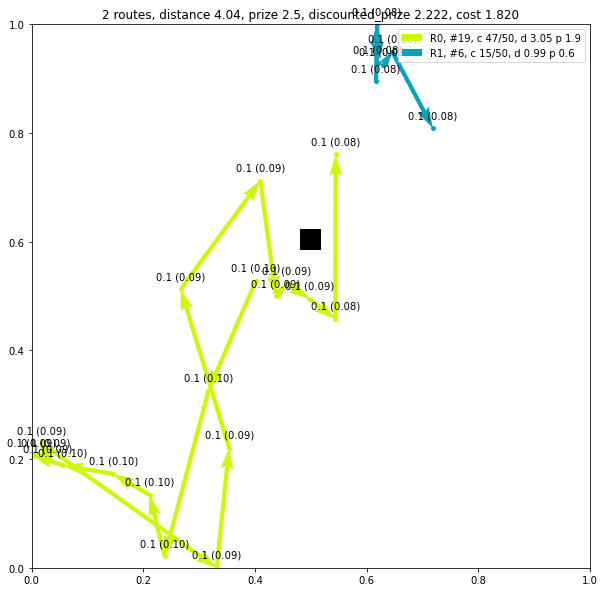

In [139]:
rg = RouteGen(sm_data_path, medic_model_path, engineer_model_path)
# rg.jl_transform_seed = 2243
# rg.jl_transform_seed = 196
# rg.jl_transform_seed = 4754
rg.jl_transform_seed = 3212


rg.get_ordered_node_list()
rg.remove_saved_victims()
rg.translate2D01space(dump_pkl='trial416.pkl')



rg.medic_model = medic_model_
rg.engineer_model = engineer_model_
medic_tour, medic_data = rg.get_medic_tour_index(medic_pickle='trial416.pkl')
print(medic_data)
# engineer_tour, engineer_data = rg.get_engineer_tour_index(medic_tour, medic_data)

medic_routes, medic_cost, medic_path_length = rg.get_medic_seperate_tour_index(medic_tour, medic_data, save_fig_path=None)
print(medic_routes)
# engineer_routes, engineer_cost, engineer_path_length = rg.get_engineer_seperate_tour_index(engineer_tour, engineer_data, save_fig_path=None)
medic_path = rg.get_medic_path_readable(medic_routes)
medic_routes = medic_routes[0] + medic_routes[1]
medic_path_ids = [rg.node_list[i].id for i in medic_routes]
print(medic_path_ids)
# engineer_path = rg.get_engineer_path_readable(engineer_routes)

In [ ]:
p2_ms = 11
p1, p2, p3, p3_m = rg.get_three_player_no_deadlock_tour(medic_routes, engineer_routes, p2_ms)
p2 = p2[:-4] + ['vg49', 'vg39', 'vg50', 'vg5']
print(p2)
fin_time, vy_log = rg.get_path_solution_time(p1, p2, p3, p3_m)
time_info = {i:j for i,j in vy_log}
rg.get_three_player_json_path(p1, p2, p3, p3_m, time_info=time_info)

In [109]:
# p1, p2, p3 = rg.get_three_player_tour(medic_routes, engineer_routes)
for p2_ms in range(1, 12):
    p1, p2, p3, p3_m = rg.get_three_player_no_deadlock_tour(medic_routes, engineer_routes, p2_ms)
# print(p1)
# print(p2)
# print(p3)
# print(p3_m)
    print(rg.get_path_solution_time(p1, p2, p3, p3_m))
# from itertools import zip_longest
for i, j, k in zip_longest(p1, p2, p3+p3_m):
    print(i, '\t', j,  '\t', k)
# rg.get_three_player_json_path(p1, p2, p3, p3_m)
# # time_log = rg.get_path_json(p1, p2, p3)

[('vy3', 88.28035104577994), ('vy1', 168.07230303709753), ('vy2', 314.62653653225067), ('vy5', 465.629362052819), ('vy4', 624.2106267358831)]
985.3736534954751 742.0239127807752 625.7106267358831
985.3736534954751
[('vy3', 88.28035104577994), ('vy1', 168.07230303709753), ('vy2', 314.62653653225067), ('vy5', 465.629362052819), ('vy4', 624.2106267358831)]
971.3945289550907 742.0239127807752 643.9228550592387
971.3945289550907
[('vy3', 88.28035104577994), ('vy1', 168.07230303709753), ('vy2', 314.62653653225067), ('vy5', 465.629362052819), ('vy4', 624.2106267358831)]
951.4684292102787 742.0239127807752 657.9019795996231
951.4684292102787
[('vy3', 88.28035104577994), ('vy1', 168.07230303709753), ('vy2', 314.62653653225067), ('vy5', 465.629362052819), ('vy4', 624.2106267358831)]
933.5842996306206 742.0239127807752 677.8280793444351
933.5842996306206
[('vy3', 88.28035104577994), ('vy1', 168.07230303709753), ('vy2', 314.62653653225067), ('vy5', 465.629362052819), ('vy4', 624.2106267358831)]
91

In [115]:
p2_ms = 11
p1, p2, p3, p3_m = rg.get_three_player_no_deadlock_tour(medic_routes, engineer_routes, p2_ms)
print(rg.get_path_solution_time(p1, p2, p3, p3_m))
print(rg.get_path_solution_distance(p1, p2, p3, p3_m))
# from itertools import zip_longest
for i, j, k in zip_longest(p1, p2, p3+p3_m):
    print(i, '\t', j,  '\t', k)
# rg.get_three_player_json_path(p1, p2, p3, p3_m)

[('vy3', 88.28035104577994), ('vy1', 168.07230303709753), ('vy2', 314.62653653225067), ('vy5', 465.629362052819), ('vy4', 624.2106267358831)]
809.3058524463871 742.0239127807752 804.7000314581679
809.3058524463871
(2481.181667338911, 1816.381826486699, 1328.5303590598612)
ew_1 	 ew_1 	 ew_1
vg24 	 vg18 	 vg16
vg26 	 vg1 	 vy3
vg22 	 vy3 	 vy1
vg16 	 vg29 	 vy2
vy3 	 vy1 	 vg23
vg27 	 vg20 	 vy5
vg7 	 vg14 	 vg36
vg1 	 vy2 	 vy4
vy1 	 vg21 	 ew_1
vg13 	 vg31 	 vg11
vg29 	 vy5 	 vg6
vg17 	 vg11 	 vg8
vg30 	 vg40 	 vg18
vg32 	 vg33 	 vg15
vg20 	 vg44 	 vg9
vg12 	 vy4 	 vg19
vy2 	 vg39 	 vg25
vg21 	 vg5 	 vg10
vg23 	 vg49 	 vg3
ew_1 	 vg50 	 vg2
vg14 	 None 	 None
vg4 	 None 	 None
vg45 	 None 	 None
vg47 	 None 	 None
vg42 	 None 	 None
vg43 	 None 	 None
vy5 	 None 	 None
vg37 	 None 	 None
vg36 	 None 	 None
vg28 	 None 	 None
vg31 	 None 	 None
vg34 	 None 	 None
vg40 	 None 	 None
vg33 	 None 	 None
vg44 	 None 	 None
vg48 	 None 	 None
vy4 	 None 	 None
vg49 	 None 	 None
vg39 	 None

In [41]:
# medic_tour
# engineer_tour
# medic_data
rg.engineer_graph_size

23

In [10]:
rg.path_time_analysis(medic_path, engineer_path)

TypeError: list indices must be integers or slices, not str

In [21]:
path_l = []
for p in medic_path:
    path_l.append(p['node_id'] if not p['is_action'] else '@' + p['node_id'])
    
path_l

['ew_1',
 'c_48_-14_50_-13|ew_1',
 'c_48_-14_50_-13|el_3',
 'c_51_-20_52_-15|el_3',
 'c_51_-20_52_-15|mce',
 'c_79_-21_85_-20|mce',
 'c_79_-21_85_-20|scw',
 'vg44',
 'c_78_-35_79_-34|scw',
 'c_78_-35_79_-34|src',
 'c_72_-38_73_-37|src',
 'c_72_-38_73_-37|srd',
 '@vy4',
 'c_72_-38_73_-37|srd',
 'c_72_-38_73_-37|src',
 'c_78_-35_79_-34|src',
 'c_78_-35_79_-34|scw',
 'vg44',
 'c_79_-68_85_-67|scw',
 'c_79_-68_85_-67|scn_2',
 'scn_2',
 'scn_3',
 '@vg28',
 'scn_3',
 'scn_2',
 'c_79_-68_85_-67|scn_2',
 'c_79_-68_85_-67|scw',
 'vg44',
 'c_79_-21_85_-20|scw',
 'c_79_-21_85_-20|mce',
 'c_64_-21_66_-20|mce',
 'c_64_-21_66_-20|sdc_5',
 'sdc_5',
 'sdc_1',
 '@vg35',
 'sdc_1',
 'sdc_5',
 'c_64_-21_66_-20|sdc_5',
 'c_64_-21_66_-20|mce',
 'vg50',
 'c_98_-21_101_-20|mce',
 'c_98_-21_101_-20|scc',
 'c_97_-48_98_-47|scc',
 'c_97_-48_98_-47|sro_2',
 'sro_2',
 'sro_1',
 '@vg41',
 'sro_1',
 'sro_2',
 'c_97_-48_98_-47|sro_2',
 'c_97_-48_98_-47|scc',
 'c_98_-65_101_-64|scc',
 'c_98_-65_101_-64|scn_4',
 'scn_4

In [16]:
rg.save_to_path_file(medic_path, engineer_path, output_path_json_path)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[]
CURR: 0  2.44  4.66  410.56
BEST: 0  2.44  4.66  410.56
[]
CURR: 1  2.74  4.96  421.03
BEST: 0  2.44  4.66  410.56
[]
CURR: 2  2.65  4.87  472.21
BEST: 0  2.44  4.66  410.56
[]
CURR: 3  2.04  4.26  492.62
BEST: 0  2.44  4.66  410.56
[]
CURR: 4  1.42  3.64  418.84
BEST: 0  2.44  4.66  410.56


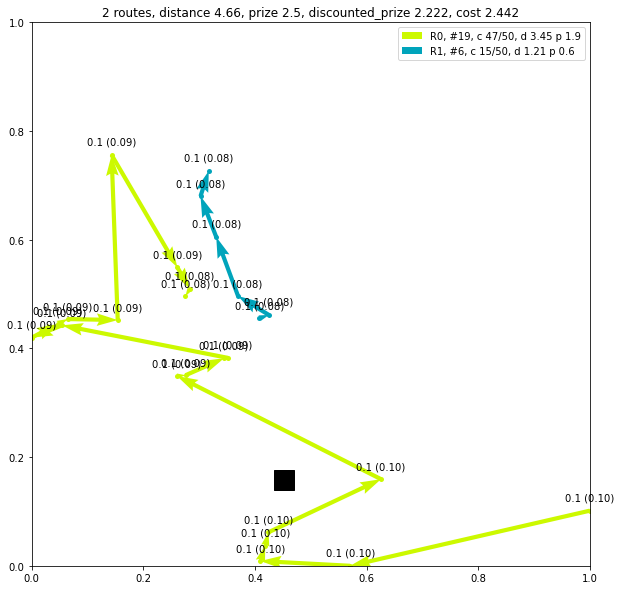

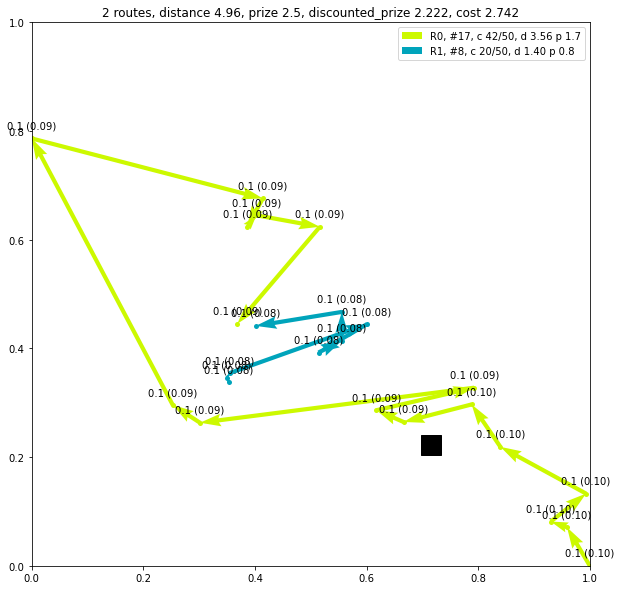

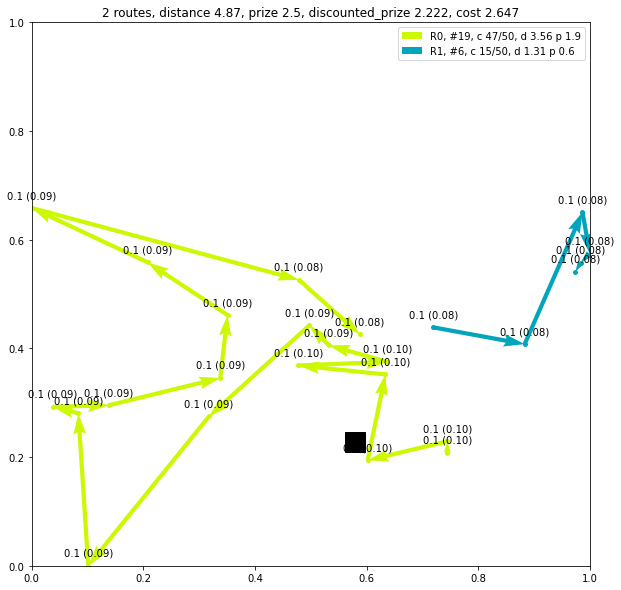

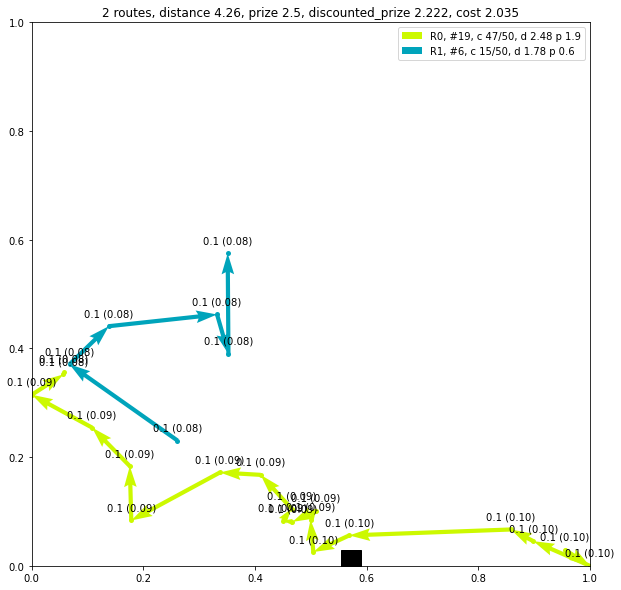

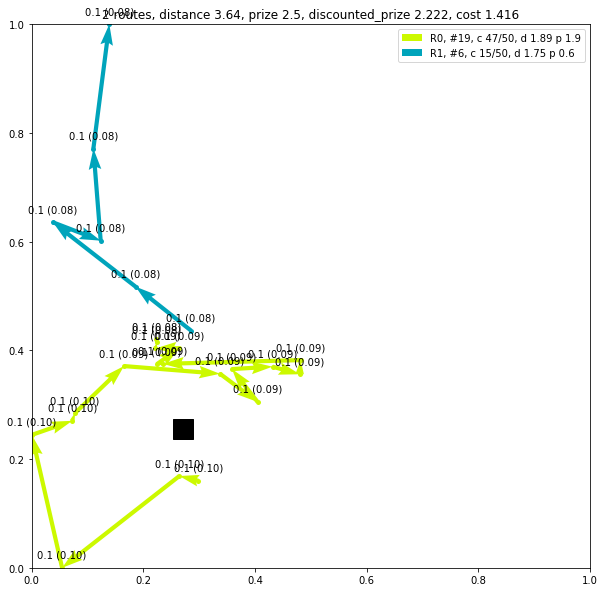

In [87]:
plt.ioff()
import warnings
warnings.filterwarnings("ignore")
rg = RouteGen(sm_data_path, medic_model_path, engineer_model_path)
rg.medic_model = medic_model_
rg.engineer_model = engineer_model_

rg.get_ordered_node_list()
rg.remove_saved_victims()
rg.find_good_seed(0, 5, verbose=True)

In [12]:
good_seeds = [1777, 1573, 1349, 674, 477, 117, 66]

In [ ]:
good_seeds = [4754, 2590, 2167]

In [ ]:
good_seeds = [403, 3212]

In [16]:
p3_victim_rescue_cord = [(-2148, 55), (-2132, 17), (-2126, 13), (-2128, 19), (-2133, 22), (-2090, 23), (-2093, 52), (-2108, 13), (-2094, 34), (-2092, 30), (-2089, 57), (-2088, 48), (-2099, 38), (-2094, 3), (-2098, 4), (-2178, 1), (-2195, -1), (-2193, -1), (-2197, -1), (-2216, 12), (-2216, 13), (-2207, 13), (-2201, 13), (-2217, 35), (-2224, 45), (-2215, 58), (-2205, 59), (-2222, 49), (-2195, 57)]
for vl in rg.graph.victim_list:
    if vl.loc in p3_victim_rescue_cord:
        print(vl.id, "True", vl.loc)
    else:
        print(vl.id, "False", vl.loc)

# saturn = [v.loc for v in rg.graph.victim_list]
        
# xs = [c[0] for c in p3_victim_rescue_cord]
# ys = [c[1] for c in p3_victim_rescue_cord]

# xss = [c[0] for c in saturn]
# yss = [c[1] for c in saturn]

# plt.scatter(xs, ys)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.scatter(xs, ys)

# plt.subplot(1, 2, 2)
# plt.scatter(xss, yss)

vg1 False (-2212, -3)
vg2 True (-2197, -1)
vg3 True (-2195, -1)
vg4 True (-2193, -1)
vg5 False (-2155, 2)
vg6 True (-2094, 3)
vg7 True (-2098, 4)
vg8 False (-2163, 5)
vg9 False (-2165, 8)
vg10 False (-2159, 8)
vg11 False (-2163, 9)
vg12 False (-2132, 9)
vg13 False (-2152, 10)
vg14 True (-2216, 12)
vg15 False (-2154, 12)
vg16 True (-2216, 13)
vg17 True (-2207, 13)
vg18 True (-2201, 13)
vg19 True (-2126, 13)
vg20 False (-2169, 14)
vg21 False (-2154, 17)
vg22 True (-2132, 17)
vg23 True (-2128, 19)
vg24 True (-2133, 22)
vg25 False (-2097, 22)
vg26 True (-2090, 23)
vg27 True (-2092, 30)
vg28 False (-2147, 34)
vg29 True (-2094, 34)
vg30 True (-2217, 35)
vg31 False (-2139, 35)
vg32 False (-2151, 37)
vg33 True (-2099, 38)
vg34 False (-2092, 38)
vg35 False (-2142, 41)
vg36 False (-2182, 42)
vg37 False (-2099, 43)
vg38 False (-2146, 44)
vg39 True (-2224, 45)
vg40 False (-2176, 45)
vg41 False (-2177, 47)
vg42 False (-2201, 48)
vg43 True (-2088, 48)
vg44 False (-2152, 50)
vg45 True (-2148, 55)
vg4

In [51]:
block_victim = {"host": "e56bcded9d61", "header": {"version": "0.6", "message_type": "groundtruth", "timestamp": "2021-06-16T01:12:17.380Z"}, "@timestamp": "2021-06-16T01:12:17.388Z", "topic": "ground_truth/mission/victims_list", "msg": {"timestamp": "2021-06-16T01:12:17.381Z", "version": "0.6", "trial_id": "f41d6856-d83b-4d36-98fc-59fab9a97b52", "sub_type": "Mission:VictimList", "experiment_id": "762477d6-ebb6-4dfc-884d-7ede1e908707", "source": "simulator"}, "data": {"mission_victim_list": [{"y": 60, "unique_id": 1, "block_type": "block_victim_1", "x": -2212, "room_name": "NA", "z": -3}, {"y": 60, "unique_id": 2, "block_type": "block_victim_1", "x": -2197, "room_name": "NA", "z": -1}, {"y": 60, "unique_id": 3, "block_type": "block_victim_1", "x": -2195, "room_name": "NA", "z": -1}, {"y": 60, "unique_id": 4, "block_type": "block_victim_1", "x": -2193, "room_name": "NA", "z": -1}, {"y": 60, "unique_id": 5, "block_type": "block_victim_proximity", "x": -2178, "room_name": "NA", "z": 1}, {"y": 60, "unique_id": 6, "block_type": "block_victim_1", "x": -2155, "room_name": "NA", "z": 2}, {"y": 60, "unique_id": 7, "block_type": "block_victim_1", "x": -2094, "room_name": "NA", "z": 3}, {"y": 60, "unique_id": 8, "block_type": "block_victim_1", "x": -2098, "room_name": "NA", "z": 4}, {"y": 60, "unique_id": 9, "block_type": "block_victim_1", "x": -2163, "room_name": "NA", "z": 5}, {"y": 60, "unique_id": 10, "block_type": "block_victim_1", "x": -2165, "room_name": "NA", "z": 8}, {"y": 60, "unique_id": 11, "block_type": "block_victim_1", "x": -2159, "room_name": "NA", "z": 8}, {"y": 60, "unique_id": 12, "block_type": "block_victim_1", "x": -2163, "room_name": "NA", "z": 9}, {"y": 60, "unique_id": 13, "block_type": "block_victim_1", "x": -2132, "room_name": "NA", "z": 9}, {"y": 60, "unique_id": 14, "block_type": "block_victim_1", "x": -2152, "room_name": "NA", "z": 10}, {"y": 60, "unique_id": 15, "block_type": "block_victim_1", "x": -2216, "room_name": "NA", "z": 12}, {"y": 60, "unique_id": 16, "block_type": "block_victim_1", "x": -2154, "room_name": "NA", "z": 12}, {"y": 60, "unique_id": 17, "block_type": "block_victim_1", "x": -2216, "room_name": "NA", "z": 13}, {"y": 60, "unique_id": 18, "block_type": "block_victim_1", "x": -2207, "room_name": "NA", "z": 13}, {"y": 60, "unique_id": 19, "block_type": "block_victim_1", "x": -2201, "room_name": "NA", "z": 13}, {"y": 60, "unique_id": 20, "block_type": "block_victim_1", "x": -2126, "room_name": "NA", "z": 13}, {"y": 60, "unique_id": 21, "block_type": "block_victim_proximity", "x": -2108, "room_name": "NA", "z": 13}, {"y": 60, "unique_id": 22, "block_type": "block_victim_1", "x": -2169, "room_name": "NA", "z": 14}, {"y": 60, "unique_id": 23, "block_type": "block_victim_1", "x": -2154, "room_name": "NA", "z": 17}, {"y": 60, "unique_id": 24, "block_type": "block_victim_1", "x": -2132, "room_name": "NA", "z": 17}, {"y": 60, "unique_id": 25, "block_type": "block_victim_1", "x": -2128, "room_name": "NA", "z": 19}, {"y": 60, "unique_id": 26, "block_type": "block_victim_1", "x": -2133, "room_name": "NA", "z": 22}, {"y": 60, "unique_id": 27, "block_type": "block_victim_1", "x": -2097, "room_name": "NA", "z": 22}, {"y": 60, "unique_id": 28, "block_type": "block_victim_1", "x": -2090, "room_name": "NA", "z": 23}, {"y": 60, "unique_id": 29, "block_type": "block_victim_1", "x": -2092, "room_name": "NA", "z": 30}, {"y": 60, "unique_id": 30, "block_type": "block_victim_1", "x": -2147, "room_name": "NA", "z": 34}, {"y": 60, "unique_id": 31, "block_type": "block_victim_1", "x": -2094, "room_name": "NA", "z": 34}, {"y": 60, "unique_id": 32, "block_type": "block_victim_1", "x": -2217, "room_name": "NA", "z": 35}, {"y": 60, "unique_id": 33, "block_type": "block_victim_1", "x": -2139, "room_name": "NA", "z": 35}, {"y": 60, "unique_id": 34, "block_type": "block_victim_1", "x": -2151, "room_name": "NA", "z": 37}, {"y": 60, "unique_id": 35, "block_type": "block_victim_1", "x": -2099, "room_name": "NA", "z": 38}, {"y": 60, "unique_id": 36, "block_type": "block_victim_1", "x": -2092, "room_name": "NA", "z": 38}, {"y": 60, "unique_id": 37, "block_type": "block_victim_proximity", "x": -2138, "room_name": "NA", "z": 40}, {"y": 60, "unique_id": 38, "block_type": "block_victim_1", "x": -2142, "room_name": "NA", "z": 41}, {"y": 60, "unique_id": 39, "block_type": "block_victim_1", "x": -2182, "room_name": "NA", "z": 42}, {"y": 60, "unique_id": 40, "block_type": "block_victim_1", "x": -2099, "room_name": "NA", "z": 43}, {"y": 60, "unique_id": 41, "block_type": "block_victim_1", "x": -2146, "room_name": "NA", "z": 44}, {"y": 60, "unique_id": 42, "block_type": "block_victim_1", "x": -2224, "room_name": "NA", "z": 45}, {"y": 60, "unique_id": 43, "block_type": "block_victim_1", "x": -2176, "room_name": "NA", "z": 45}, {"y": 60, "unique_id": 44, "block_type": "block_victim_1", "x": -2177, "room_name": "NA", "z": 47}, {"y": 60, "unique_id": 45, "block_type": "block_victim_1", "x": -2201, "room_name": "NA", "z": 48}, {"y": 60, "unique_id": 46, "block_type": "block_victim_1", "x": -2088, "room_name": "NA", "z": 48}, {"y": 60, "unique_id": 47, "block_type": "block_victim_proximity", "x": -2222, "room_name": "NA", "z": 49}, {"y": 60, "unique_id": 48, "block_type": "block_victim_1", "x": -2152, "room_name": "NA", "z": 50}, {"y": 60, "unique_id": 49, "block_type": "block_victim_proximity", "x": -2093, "room_name": "NA", "z": 52}, {"y": 60, "unique_id": 50, "block_type": "block_victim_1", "x": -2148, "room_name": "NA", "z": 55}, {"y": 60, "unique_id": 51, "block_type": "block_victim_1", "x": -2224, "room_name": "NA", "z": 57}, {"y": 60, "unique_id": 52, "block_type": "block_victim_1", "x": -2195, "room_name": "NA", "z": 57}, {"y": 60, "unique_id": 53, "block_type": "block_victim_1", "x": -2089, "room_name": "NA", "z": 57}, {"y": 60, "unique_id": 54, "block_type": "block_victim_1", "x": -2215, "room_name": "NA", "z": 58}, {"y": 60, "unique_id": 55, "block_type": "block_victim_1", "x": -2205, "room_name": "NA", "z": 59}], "elapsed_milliseconds": 9, "mission_timer": "15 : 3", "mission": "Saturn_B"}, "@version": "1"}
xss = [c['x'] for c in block_victim['data']['mission_victim_list']]
yss = [c['z'] for c in block_victim['data']['mission_victim_list']]

In [7]:
block_victim = {"host": "e56bcded9d61", "header": {"version": "0.6", "message_type": "groundtruth", "timestamp": "2021-06-16T01:12:17.380Z"}, "@timestamp": "2021-06-16T01:12:17.388Z", "topic": "ground_truth/mission/victims_list", "msg": {"timestamp": "2021-06-16T01:12:17.381Z", "version": "0.6", "trial_id": "f41d6856-d83b-4d36-98fc-59fab9a97b52", "sub_type": "Mission:VictimList", "experiment_id": "762477d6-ebb6-4dfc-884d-7ede1e908707", "source": "simulator"}, "data": {"mission_victim_list": [{"y": 60, "unique_id": 1, "block_type": "block_victim_1", "x": -2212, "room_name": "NA", "z": -3}, {"y": 60, "unique_id": 2, "block_type": "block_victim_1", "x": -2197, "room_name": "NA", "z": -1}, {"y": 60, "unique_id": 3, "block_type": "block_victim_1", "x": -2195, "room_name": "NA", "z": -1}, {"y": 60, "unique_id": 4, "block_type": "block_victim_1", "x": -2193, "room_name": "NA", "z": -1}, {"y": 60, "unique_id": 5, "block_type": "block_victim_proximity", "x": -2178, "room_name": "NA", "z": 1}, {"y": 60, "unique_id": 6, "block_type": "block_victim_1", "x": -2155, "room_name": "NA", "z": 2}, {"y": 60, "unique_id": 7, "block_type": "block_victim_1", "x": -2094, "room_name": "NA", "z": 3}, {"y": 60, "unique_id": 8, "block_type": "block_victim_1", "x": -2098, "room_name": "NA", "z": 4}, {"y": 60, "unique_id": 9, "block_type": "block_victim_1", "x": -2163, "room_name": "NA", "z": 5}, {"y": 60, "unique_id": 10, "block_type": "block_victim_1", "x": -2165, "room_name": "NA", "z": 8}, {"y": 60, "unique_id": 11, "block_type": "block_victim_1", "x": -2159, "room_name": "NA", "z": 8}, {"y": 60, "unique_id": 12, "block_type": "block_victim_1", "x": -2163, "room_name": "NA", "z": 9}, {"y": 60, "unique_id": 13, "block_type": "block_victim_1", "x": -2132, "room_name": "NA", "z": 9}, {"y": 60, "unique_id": 14, "block_type": "block_victim_1", "x": -2152, "room_name": "NA", "z": 10}, {"y": 60, "unique_id": 15, "block_type": "block_victim_1", "x": -2216, "room_name": "NA", "z": 12}, {"y": 60, "unique_id": 16, "block_type": "block_victim_1", "x": -2154, "room_name": "NA", "z": 12}, {"y": 60, "unique_id": 17, "block_type": "block_victim_1", "x": -2216, "room_name": "NA", "z": 13}, {"y": 60, "unique_id": 18, "block_type": "block_victim_1", "x": -2207, "room_name": "NA", "z": 13}, {"y": 60, "unique_id": 19, "block_type": "block_victim_1", "x": -2201, "room_name": "NA", "z": 13}, {"y": 60, "unique_id": 20, "block_type": "block_victim_1", "x": -2126, "room_name": "NA", "z": 13}, {"y": 60, "unique_id": 21, "block_type": "block_victim_proximity", "x": -2108, "room_name": "NA", "z": 13}, {"y": 60, "unique_id": 22, "block_type": "block_victim_1", "x": -2169, "room_name": "NA", "z": 14}, {"y": 60, "unique_id": 23, "block_type": "block_victim_1", "x": -2154, "room_name": "NA", "z": 17}, {"y": 60, "unique_id": 24, "block_type": "block_victim_1", "x": -2132, "room_name": "NA", "z": 17}, {"y": 60, "unique_id": 25, "block_type": "block_victim_1", "x": -2128, "room_name": "NA", "z": 19}, {"y": 60, "unique_id": 26, "block_type": "block_victim_1", "x": -2133, "room_name": "NA", "z": 22}, {"y": 60, "unique_id": 27, "block_type": "block_victim_1", "x": -2097, "room_name": "NA", "z": 22}, {"y": 60, "unique_id": 28, "block_type": "block_victim_1", "x": -2090, "room_name": "NA", "z": 23}, {"y": 60, "unique_id": 29, "block_type": "block_victim_1", "x": -2092, "room_name": "NA", "z": 30}, {"y": 60, "unique_id": 30, "block_type": "block_victim_1", "x": -2147, "room_name": "NA", "z": 34}, {"y": 60, "unique_id": 31, "block_type": "block_victim_1", "x": -2094, "room_name": "NA", "z": 34}, {"y": 60, "unique_id": 32, "block_type": "block_victim_1", "x": -2217, "room_name": "NA", "z": 35}, {"y": 60, "unique_id": 33, "block_type": "block_victim_1", "x": -2139, "room_name": "NA", "z": 35}, {"y": 60, "unique_id": 34, "block_type": "block_victim_1", "x": -2151, "room_name": "NA", "z": 37}, {"y": 60, "unique_id": 35, "block_type": "block_victim_1", "x": -2099, "room_name": "NA", "z": 38}, {"y": 60, "unique_id": 36, "block_type": "block_victim_1", "x": -2092, "room_name": "NA", "z": 38}, {"y": 60, "unique_id": 37, "block_type": "block_victim_proximity", "x": -2138, "room_name": "NA", "z": 40}, {"y": 60, "unique_id": 38, "block_type": "block_victim_1", "x": -2142, "room_name": "NA", "z": 41}, {"y": 60, "unique_id": 39, "block_type": "block_victim_1", "x": -2182, "room_name": "NA", "z": 42}, {"y": 60, "unique_id": 40, "block_type": "block_victim_1", "x": -2099, "room_name": "NA", "z": 43}, {"y": 60, "unique_id": 41, "block_type": "block_victim_1", "x": -2146, "room_name": "NA", "z": 44}, {"y": 60, "unique_id": 42, "block_type": "block_victim_1", "x": -2224, "room_name": "NA", "z": 45}, {"y": 60, "unique_id": 43, "block_type": "block_victim_1", "x": -2176, "room_name": "NA", "z": 45}, {"y": 60, "unique_id": 44, "block_type": "block_victim_1", "x": -2177, "room_name": "NA", "z": 47}, {"y": 60, "unique_id": 45, "block_type": "block_victim_1", "x": -2201, "room_name": "NA", "z": 48}, {"y": 60, "unique_id": 46, "block_type": "block_victim_1", "x": -2088, "room_name": "NA", "z": 48}, {"y": 60, "unique_id": 47, "block_type": "block_victim_proximity", "x": -2222, "room_name": "NA", "z": 49}, {"y": 60, "unique_id": 48, "block_type": "block_victim_1", "x": -2152, "room_name": "NA", "z": 50}, {"y": 60, "unique_id": 49, "block_type": "block_victim_proximity", "x": -2093, "room_name": "NA", "z": 52}, {"y": 60, "unique_id": 50, "block_type": "block_victim_1", "x": -2148, "room_name": "NA", "z": 55}, {"y": 60, "unique_id": 51, "block_type": "block_victim_1", "x": -2224, "room_name": "NA", "z": 57}, {"y": 60, "unique_id": 52, "block_type": "block_victim_1", "x": -2195, "room_name": "NA", "z": 57}, {"y": 60, "unique_id": 53, "block_type": "block_victim_1", "x": -2089, "room_name": "NA", "z": 57}, {"y": 60, "unique_id": 54, "block_type": "block_victim_1", "x": -2215, "room_name": "NA", "z": 58}, {"y": 60, "unique_id": 55, "block_type": "block_victim_1", "x": -2205, "room_name": "NA", "z": 59}], "elapsed_milliseconds": 9, "mission_timer": "15 : 3", "mission": "Saturn_B"}, "@version": "1"}
green_list = []
yellow_list = []
green_count = 1
yellow_count = 1
for c in block_victim['data']['mission_victim_list']:
    if c["block_type"] == "block_victim_1":
        green_list.append({
          "id": "vg" + str(green_count),
          "type": "green_victim",
          "bounds": {
            "type": "block",
            "coordinates": [
              {
                "x": c['x'],
                "y": c['y'],
                "z": c['z']
              }
            ]
          }
        })
        green_count += 1
    else:
        yellow_list.append({
          "id": "vy" + str(yellow_count),
          "type": "yellow_victim",
          "bounds": {
            "type": "block",
            "coordinates": [
              {
                "x": c['x'],
                "y": c['y'],
                "z": c['z']
              }
            ]
          }
        })
        yellow_count += 1

json.dumps(green_list + yellow_list)
# print(green_list + yellow_list)

'[{"id": "vg1", "type": "green_victim", "bounds": {"type": "block", "coordinates": [{"x": -2212, "y": 60, "z": -3}]}}, {"id": "vg2", "type": "green_victim", "bounds": {"type": "block", "coordinates": [{"x": -2197, "y": 60, "z": -1}]}}, {"id": "vg3", "type": "green_victim", "bounds": {"type": "block", "coordinates": [{"x": -2195, "y": 60, "z": -1}]}}, {"id": "vg4", "type": "green_victim", "bounds": {"type": "block", "coordinates": [{"x": -2193, "y": 60, "z": -1}]}}, {"id": "vg5", "type": "green_victim", "bounds": {"type": "block", "coordinates": [{"x": -2155, "y": 60, "z": 2}]}}, {"id": "vg6", "type": "green_victim", "bounds": {"type": "block", "coordinates": [{"x": -2094, "y": 60, "z": 3}]}}, {"id": "vg7", "type": "green_victim", "bounds": {"type": "block", "coordinates": [{"x": -2098, "y": 60, "z": 4}]}}, {"id": "vg8", "type": "green_victim", "bounds": {"type": "block", "coordinates": [{"x": -2163, "y": 60, "z": 5}]}}, {"id": "vg9", "type": "green_victim", "bounds": {"type": "block", 

In [20]:
save_before_change = [(-2148, 55), (-2132, 17), (-2126, 13), (-2128, 19), (-2133, 22), (-2090, 23), (-2093, 52), (-2108, 13), (-2094, 34), (-2092, 30), (-2089, 57), (-2088, 48), (-2099, 38), (-2094, 3), (-2098, 4), (-2178, 1), (-2195, -1), (-2193, -1), (-2197, -1), (-2216, 12), (-2216, 13)]
save_after_change = [(-2207, 13), (-2201, 13), (-2217, 35), (-2224, 45), (-2215, 58), (-2205, 59), (-2222, 49), (-2195, 57)]
save_before_list = []
save_after_list = []
unsave_list = []
for v in rg.graph.victim_list:
    if v.loc in save_before_change:
        save_before_list.append(v.id) 
    elif v.loc in save_after_change:
        save_after_list.append(v.id)
    else:
        unsave_list.append(v.id)

print(save_before_list)
print(save_after_list)
print(unsave_list)

['vg2', 'vg3', 'vg4', 'vg6', 'vg7', 'vg14', 'vg16', 'vg19', 'vg22', 'vg23', 'vg24', 'vg26', 'vg27', 'vg29', 'vg33', 'vg43', 'vg45', 'vg48', 'vy1', 'vy2', 'vy5']
['vg17', 'vg18', 'vg30', 'vg39', 'vg47', 'vg49', 'vg50', 'vy4']
['vg1', 'vg5', 'vg8', 'vg9', 'vg10', 'vg11', 'vg12', 'vg13', 'vg15', 'vg20', 'vg21', 'vg25', 'vg28', 'vg31', 'vg32', 'vg34', 'vg35', 'vg36', 'vg37', 'vg38', 'vg40', 'vg41', 'vg42', 'vg44', 'vg46', 'vy3']


In [140]:
# p1 = ['vg38', 'vg35', 'vg32', 'vg21', 'vg13', 'vg15', 'vg5', 'vy4', 'vg46', 'vg47', 'vg36', 'vg40', 'vg41', 'vg44', 'vg28', 'vg20', 'vg9', 'vg11', 'vg8', 'vg10']
# p2 = ['vg30', 'vg44','vg28', 'vg42', 'vg46', 'vy4', 'vg47', 'vg36', 'vg41', 'vg10']

p1 = ['vg38', 'vg35', 'vg32', 'vg21', 'vg13', 'vg15', 'vg5', 'vg12', 'vy4', 'vg46', 'vg47', 'vg36', 'vg40', 'vg41', 'vg44', 'vg28', 'vg9', 'vg11']
p2 = ['vg30', 'vg44','vg28', 'vg42', 'vg46', 'vy4', 'vg47', 'vg36', 'vg41', 'vg10']
p3 = []
p3_m = []
rg.get_path_solution_time(p1, p2, p3, p3_m)
time_info = {'vy4': 127.15}
rg.get_two_player_json_path(p1, p2, time_info=time_info)
rg.get_two_path_solution_distance(p1, p2)

248.76370276444675 170.72883924781718 111.48842226378227


(638.8969547251334, 519.1130589170035)

In [ ]:
91 98.93